# Garbage Classification


#### Import & Config

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from torchvision import models, transforms

import numpy as np
import cv2
import os
from glob import glob
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

#### Seed

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


#### Hyperparameters

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4

#### Load dataset

In [4]:
def load_dataset_from_folder(root_dir):
    image_paths = []
    labels = []

    class_names = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

    for cls in class_names:
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        for img_path in glob(os.path.join(cls_path, "*.jpg")):
            image_paths.append(img_path)
            labels.append(class_to_idx[cls])

    return image_paths, labels, class_names

X_paths, y, class_names = load_dataset_from_folder("garbage-dataset")

X_train, X_test, y_train, y_test = train_test_split(
    X_paths, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

NUM_CLASSES = len(class_names)

class GarbageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

#### Transform

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

#### Prepare & Loader

In [6]:
train_dataset = GarbageDataset(X_train, y_train, train_transform)
test_dataset  = GarbageDataset(X_test, y_test, test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)


#### Model

In [7]:
model = models.efficientnet_b0(weights="DEFAULT")

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

model = model.to(device)

#### Loss Optimized

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scaler = GradScaler()

/tmp/ipykernel_1137/2501172290.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


#### Training Loop

In [9]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= len(test_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Acc: {val_acc:.2f}%")

  0%|          | 0/247 [00:00<?, ?it/s]/tmp/ipykernel_1137/1687824492.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


Epoch 1/20 | Train Acc: 81.46% | Val Acc: 93.18%


100%|██████████| 247/247 [00:41<00:00,  5.90it/s]


Epoch 2/20 | Train Acc: 93.99% | Val Acc: 95.51%


100%|██████████| 247/247 [00:41<00:00,  5.91it/s]


Epoch 3/20 | Train Acc: 96.22% | Val Acc: 96.25%


100%|██████████| 247/247 [00:42<00:00,  5.87it/s]


Epoch 4/20 | Train Acc: 97.52% | Val Acc: 96.58%


100%|██████████| 247/247 [00:45<00:00,  5.48it/s]


Epoch 5/20 | Train Acc: 98.21% | Val Acc: 96.88%


100%|██████████| 247/247 [00:44<00:00,  5.53it/s]


Epoch 6/20 | Train Acc: 98.78% | Val Acc: 97.03%


100%|██████████| 247/247 [00:45<00:00,  5.43it/s]


Epoch 7/20 | Train Acc: 98.84% | Val Acc: 97.09%


100%|██████████| 247/247 [00:45<00:00,  5.49it/s]


Epoch 8/20 | Train Acc: 99.12% | Val Acc: 96.96%


100%|██████████| 247/247 [00:44<00:00,  5.55it/s]


Epoch 9/20 | Train Acc: 99.10% | Val Acc: 97.01%


100%|██████████| 247/247 [00:43<00:00,  5.73it/s]


Epoch 10/20 | Train Acc: 99.24% | Val Acc: 97.03%


100%|██████████| 247/247 [00:43<00:00,  5.71it/s]


Epoch 11/20 | Train Acc: 99.40% | Val Acc: 97.09%


100%|██████████| 247/247 [00:42<00:00,  5.76it/s]


Epoch 12/20 | Train Acc: 99.43% | Val Acc: 97.47%


100%|██████████| 247/247 [00:42<00:00,  5.79it/s]


Epoch 13/20 | Train Acc: 99.53% | Val Acc: 97.24%


100%|██████████| 247/247 [00:43<00:00,  5.72it/s]


Epoch 14/20 | Train Acc: 99.52% | Val Acc: 97.11%


100%|██████████| 247/247 [00:44<00:00,  5.54it/s]


Epoch 15/20 | Train Acc: 99.48% | Val Acc: 97.54%


100%|██████████| 247/247 [00:43<00:00,  5.68it/s]


Epoch 16/20 | Train Acc: 99.55% | Val Acc: 97.36%


100%|██████████| 247/247 [00:45<00:00,  5.41it/s]


Epoch 17/20 | Train Acc: 99.56% | Val Acc: 97.57%


100%|██████████| 247/247 [00:44<00:00,  5.57it/s]


Epoch 18/20 | Train Acc: 99.61% | Val Acc: 97.29%


100%|██████████| 247/247 [00:44<00:00,  5.55it/s]


Epoch 19/20 | Train Acc: 99.68% | Val Acc: 97.16%


100%|██████████| 247/247 [00:42<00:00,  5.79it/s]


Epoch 20/20 | Train Acc: 99.65% | Val Acc: 97.21%


#### Learning Curve

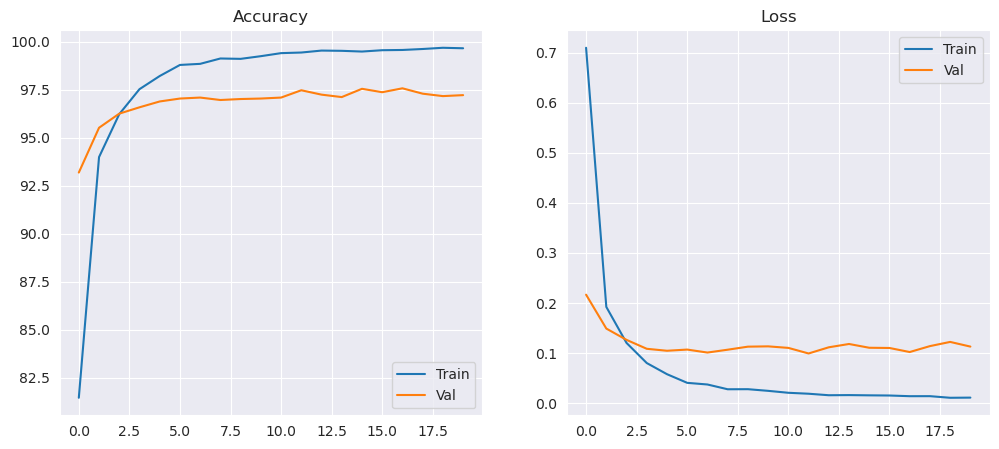

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.show()

#### Evaluation

Predicting: 100%|██████████| 62/62 [00:10<00:00,  5.76it/s]

Test Accuracy: 0.9721236695387735

Classification Report:

              precision    recall  f1-score   support

     battery       0.97      0.99      0.98       189
  biological       0.99      0.98      0.99       199
   cardboard       0.97      0.97      0.97       365
     clothes       0.99      0.99      0.99      1065
       glass       0.97      0.98      0.97       611
       metal       0.94      0.92      0.93       203
       paper       0.96      0.95      0.96       336
     plastic       0.95      0.95      0.95       395
       shoes       0.97      0.98      0.97       395
       trash       0.95      0.95      0.95       188

    accuracy                           0.97      3946
   macro avg       0.97      0.97      0.97      3946
weighted avg       0.97      0.97      0.97      3946



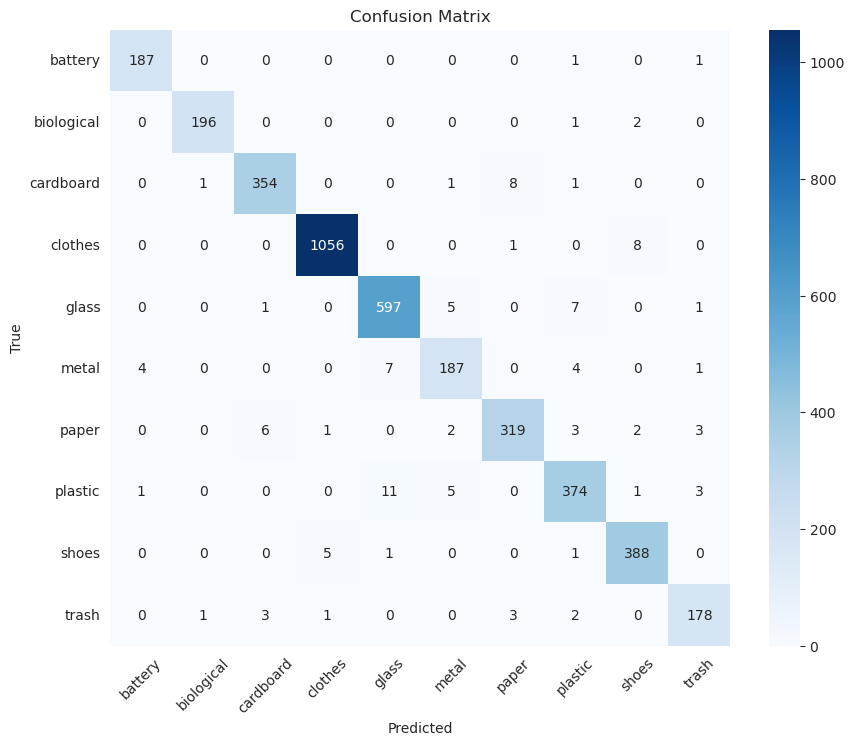

In [11]:
def get_predictions(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Predicting"):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)


y_test_true, y_test_pred = get_predictions(model, test_loader)

print("Test Accuracy:", accuracy_score(y_test_true, y_test_pred))
print("\nClassification Report:\n")
print(classification_report(y_test_true, y_test_pred, target_names=class_names))

cm = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

#### Export Model

In [16]:
#Mapping
DATASET_PATH = "garbage-dataset"

classes = sorted([
    d for d in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, d))
])

class_to_idx = {cls: i for i, cls in enumerate(classes)}

print("Classes:", classes)
print("Mapping:", class_to_idx)

#Export
EXPORT_PATH = "garbage_model.pth"

model.eval()
model.cpu()

torch.save({
    "model_state_dict": model.state_dict(),
    "class_names": classes
}, EXPORT_PATH)


Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Mapping: {'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}
